Техническая задача: сделать модуль сравнения тем 1 к 1 с оригинальными, разные расстояния + визуализация. 

In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize
    

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_05_03_100_topics\models.txt


In [3]:
def create_model_100_fn_1(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100 + n_iteration,
                             n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_100_m1_iter_{}'.format(n_iteration))
    return tmp_model
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def save_model_pickle(_model_name, _model, _save=True):
    phi = _model.get_phi()
    phi = phi[(phi.T != 0).any()]
    theta = _model.get_theta()    
    saved_top_tokens = _model.score_tracker['top_tokens_score'].last_tokens
    if _save:
        save_pickle_file(phi, 'phi_{}.p'.format(_model_name))
        save_pickle_file(theta, 'theta_{}.p'.format(_model_name))
        save_pickle_file(saved_top_tokens, 'saved_top_tokens_{}.p'.format(_model_name))
    return phi, theta, saved_top_tokens
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def load_model_pickle(_model_name, _distance_name=None, _path=config.experiment_path):
    phi = load_pickle_file('phi_{}.p'.format(_model_name), _path)
    theta = load_pickle_file('theta_{}.p'.format(_model_name), _path)
    saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name), _path)
    distances = None
    if _distance_name is not None:
        distances = load_pickle_file('{}.p'.format(_distance_name), _path)
    return phi, theta, saved_top_tokens, distances

Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [4]:
phi_original, theta_original, saved_top_tokens_original, distances_hellinger_model_original = load_model_pickle('model3', 'distances_hellinger_model3', config.output_batches_path)
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


# task1
Найти модель (1 итерация filter ch), которая
* будет иметь гранулярность близкую к original (=55)
* будет иметь opt_res_mean - через 1

In [5]:
models_count = 20
names_list, phi_convex_hull_list =  [0] * models_count,  [0] * models_count
iterations_info_list, iterations_filtering_list =  [0] * models_count, [0] * models_count
distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list = [0] * models_count, [0] * models_count, [0] * models_count

In [6]:
idx = 0

get_result_one_matrix_fn = bchh.get_optimization_result_one_matrix
OPT_FUN_THRESHOLD, N_CLOSEST_TOPICS_COUNT, DIST_FN  = 0.6, 15, dh.hellinger_dist
names_list[idx] = 'hellinger__wf__model_100_m1__0.6__15_r1'
phi_convex_hull_list[idx], iterations_info_list[idx], iterations_filtering_list[idx] = bchh \
                                                    .build_convex_hull_with_filtering(
                                                     create_model_100_fn_1,
                                                     bchh.get_topics_to_remove_by_opt_fun_and_distance, 
                                                     DIST_FN,
                                                     get_result_one_matrix_fn,
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     n_closest_topics_count=N_CLOSEST_TOPICS_COUNT,
                                                     opt_fun_threshold=OPT_FUN_THRESHOLD,
                                                     use_previous_iterations=True,
                                                     max_iteration=1)

[2017-03-08 14:47:41.846000] ********** iteration = 1 / 1
name = model_100_m1_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25

[2017-03-08 14:49:30.603000] filtering iteration = 1 / 50
[2017-03-08 14:50:12.401000] 4 topics to remove, 7 not_removed_topics_count because close topics, current convex_hull shape = (2216, 96)
[2017-03-08 14:50:12.401000] filtering iteration = 2 / 50
[2017-03-08 14:50:47.318000] 1 topics to remove, 4 not_removed_topics_count because close topics, current convex_hull shape = (2216, 95)
[2017-03-08 14:50:47.318000] filtering iteration = 3 / 50
[2017-03-08 14:51:12.504000] 1 topics to remove, 2 not_removed_topics_count because close topics, current convex_hull shape = (2216, 94)
[2017-03-08 14:51:12.504000] filtering iteration = 4 / 50
[2017-03-08 14:51:47.888000] 1 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 93)
[2017-03-08 1

In [7]:
different_distances = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_original)

Processed th = 0.95, original columns count = 0     

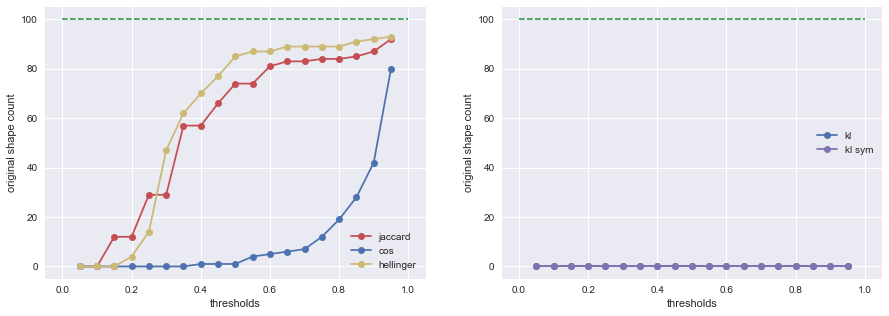

In [8]:
%matplotlib inline
tvsoch.plot_original_columns_count_different_distances(different_distances, n_original_columns_count=100)

## Test hungarian algorithm

In [9]:
test_mat = pd.DataFrame([[0.1, 0.2, 0.8], [0.8, 0.7, 0.2]])
res = tvsoch.get_hungarian_alg_result(test_mat, 0.5)
for val in res:
    print val
print "____________________________________________________________________________"
res = tvsoch.get_hungarian_alg_result(test_mat, 0.1)
for val in res:
    print val

[(0, 0, 0, 0, 0.10000000000000001), (1, 2, 1, 2, 0.20000000000000001)]
       0      1      2          0          1
0    0.1    0.2  100.0    0.50000  100.00000
1  100.0  100.0    0.2  100.00000    0.50000
0    0.5  100.0  100.0    0.00001    0.00001
1  100.0    0.5  100.0    0.00001    0.00001
2  100.0  100.0    0.5    0.00001    0.00001
[0 1 2 3 4]
[0 2 4 1 3]
____________________________________________________________________________
[(0, 0, 0, 0, 0.10000000000000001)]
       0      1      2          0          1
0    0.1  100.0  100.0    0.10000  100.00000
1  100.0  100.0  100.0  100.00000    0.10000
0    0.1  100.0  100.0    0.00001    0.00001
1  100.0    0.1  100.0    0.00001    0.00001
2  100.0  100.0    0.1    0.00001    0.00001
[0 1 2 3 4]
[0 4 3 1 2]


In [50]:
row_ind, col_ind = linear_sum_assignment(jac_cost)
for ind in range(len(row_ind)):
    print jac_cost.iloc[row_ind[ind], col_ind[ind]]
    print ' '.join(phi_convex_hull_list[idx].iloc[:, row_ind[ind]].sort_values()[::-1][0:N_CLOSEST_TOPICS_COUNT].index)
    print ' '.join(phi_original.iloc[:, col_ind[ind]].sort_values()[::-1][0:N_CLOSEST_TOPICS_COUNT].index)
    print '---------------------------'

0.333333333333
тело самец птица самка микроорганизм сигнал шимпанзе примат вид рыба группа динозавр боль еврей здоровье
тело самец самка птица микроорганизм шимпанзе сигнал примат рыба динозавр группа вид болото размер вода
---------------------------
0.333333333333
система задача компьютер программа математика область проблема число работа подход простой образ сложность алгоритм помощь
система задача компьютер программа математика область алгоритм сложность проблема математик подход число схема вычисление работа
---------------------------
0.333333333333
вариант раса целое лицо идеал человечество справедливость признак предприятие идея комиссия акцент достижение тип изменчивость
вариант раса идеал справедливость предприятие комиссия акцент лицо человечество целое изменчивость роберт признак высокий_образование античность
---------------------------
0.421052631579
нейрон связь автомобиль стимул феномен момент активность работник работа блок процесс область выполнение синапс изменение
н